In [18]:
#Necessary packages
using  DataFrames, CSV, NaNMath
using DifferentialEquations, LinearAlgebra
using Turing, MCMCChains, Distributions
using StatsPlots
using Random
using Logging
Random.seed!(14);
disable_logging(LogLevel(1000))

LogLevel(1001)

We assume that the meningioma tumor follows the Gompertz model.

**Gompertz model**
$$ 
\frac{du}{dt} = (1 + e) \cdot u \cdot \alpha \cdot e^{-\beta t}
$$

- $e$: Error in the measurement of the initial tumor volume.
- $\alpha$: Growth rate.
- $\beta$: Decay rate.


In [19]:
#Gompertz model
function gompertz(du , u , p , t )

    #model parameters
    e , α, β = p

    du[1] = (1+e)*u[1]*α* NaNMath.exp(-β*t)

    return nothing

end 

gompertz (generic function with 1 method)

In [20]:
#Patients data
function patient_data(data::DataFrame , id)
    pdata = data[data.patient_id .== id , :]
    return pdata.days[:] , pdata.volume[:]
end 

patient_data (generic function with 1 method)

In [21]:
#Creating model  

@model function fitmodel(data::DataFrame  , id )

    # Prior distributions.
     e ~ Normal(0.0, 0.5) # 0.0 1.0 
     α ~ truncated(Normal(1.0, 0.3) ; lower=0.0 , upper=3.0) 
     β ~ truncated(Normal(0.5, 1.0) ; lower=0.0 , upper=2.0)  
     
    #Try different solvers
     solveur = [Tsit5() , Vern9() , Vern7()]

    #Patients data & normalization
     jours , volumes= patient_data(data , id )
     volumes = volumes ./volumes[begin]
     jours = jours ./ jours[end]
     u0 = [volumes[1]]    
     p = [e , α , β]
     tspan=(jours[begin] , jours[end])
     prob = ODEProblem(gompertz, u0, tspan , p)
     selected_solver = nothing 
     for s in solveur 
        try 
            sol = solve(prob,s; p=p, saveat=jours) 
            selected_solver = s
            predicted =[sol.u[i][1] for i in 1:length(jours) ]
            for i in 1:length(predicted)
                volumes[i] ~ LogNormal(predicted[i], 1)
            end
            break
        catch 
            continue 
        end 
     end 
     return nothing
end

fitmodel (generic function with 2 methods)

In [22]:
#Read data
dataset = CSV.read("volumedf.csv" , DataFrame)

#This vector will contain the IDs of patients whose tumors increase over time
increase=[]
patient_ids = unique(dataset[: , :patient_id])

for id in patient_ids
    if issorted(patient_data(dataset , id)[2])
      append!(increase , id )
    end 
 end 
increase[1:4]

4-element Vector{Any}:
  4
  5
  9
 27

In [23]:
#Tabs to store posterior parameters corresponding to each patient and max log posterior
e_p, alpha_p, beta_p, lp_p = [], [], [], []

for id in increase

    model = fitmodel(dataset , id)
    
    #Chain 
    chain = sample(model, NUTS(), MCMCSerial(), 3000,2; progress=true)  
    plot(chain, [:e , :α , :β])

    #Plot patient parameters 
    #path = "Bayesian-inference"
    filename = "patient_params_$id.png"
    savefig( filename)
    
    #Plot les informations correspondants  
    #chemin = "Bayesian-inference"
    file_info = "information_$id.csv"
    #full_path = joinpath(chemin, file_info)
    CSV.write(file_info , chain)
    df = CSV.File("information_$id.csv") |> DataFrame
    _, i = findmax(df[! , :lp]) # Log posterior : lp
    append!(e_p , df[i , :e])
    append!(alpha_p , df[i , :α])
    append!(beta_p , df[i , :β ])
    append!(lp_p , df[i , :lp])   
end 
results =DataFrame((Patient_id = increase, e = e_p , alpha = alpha_p , beta = beta_p , lp = lp_p))


Row,Patient_id,e,alpha,beta,lp
,Any,Any,Any,Any,Any
1,4,-0.103659,1.09172,1.02729,-6.46839
2,5,-0.0213474,1.09151,0.820021,-4.44016
3,9,-0.0334359,1.00459,0.77762,-4.39007
4,27,-0.0856145,1.08235,0.908062,-4.40842
5,29,-0.00695742,1.05703,0.934124,-4.34129
6,42,-0.0153088,1.03022,0.683548,-5.30705
7,43,0.0846956,1.02718,1.02308,-4.41742
8,48,-0.0910863,1.00112,1.11292,-10.2618
9,51,0.110835,0.970344,0.798817,-9.59228


Parameters [e, α, β]: [-0.10365899123691713, 0.0003517144497498262, 0.00033095840191379555]
Predicted volumes: [476.75, 611.1871940208554, 708.8168399369097, 795.5242196202386, 878.799977451949]
Real volumes: [476.75, 663.833333333333, 744.041666666667, 1373.58333333333, 1742.66666666667]


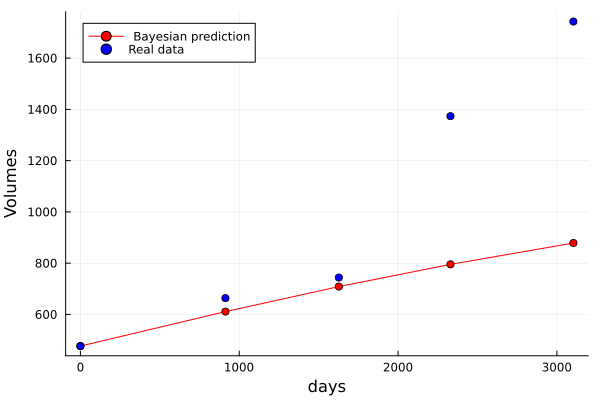

In [37]:
id = 4
days , volumes = patient_data(dataset , id)
p = [results[results.Patient_id .==id  , :e][1] , results[results.Patient_id .==id  , :alpha][1] , results[results.Patient_id .==id  , :beta][1]] # params corresponding to max lp
tp = [p[1],p[2]/days[end], p[3]/days[end] ] #True params
println("Parameters [e, α, β]: ",tp)
#days1 = days ./days[end]
#volumes = volumes ./ volumes[begin]
prediction = volumes[1] * exp.(((1+tp[1]) * tp[2] / tp[3]) * (1 .- exp.(-tp[3] * days)))
println("Predicted volumes: ", prediction)
println("Real volumes: ", volumes)
plt = plot(days, prediction, xlabel = "days", ylabel = "Volumes", color = :red, label = [" Bayesian prediction" nothing] , shape = :circle)
scatter!(days , volumes , color = :blue , label = ["Real data " nothing] , shape = :circle )